# import important library

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from textwrap import wrap
from google.colab import drive

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


# Path of data [ image and caption ]

In [ ]:
# image_path = "/content/drive/MyDrive/Machine Learning/project/Flicker8k_Dataset"
image_path = "/content/drive/MyDrive/MachineLearning/project/Image"

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/Machine Learning/project/captions.txt')
data = pd.read_csv("/content/drive/MyDrive/MachineLearning/project/MyData/captions.csv")
data.head()

,image,caption
0,IMG_0225.JPG,A student use computer on white table .
1,IMG_0225.JPG,A man in a white shirt is play computer .
2,IMG_0225.JPG,A student install programe on computer .
3,IMG_0225.JPG,A student sitting on the chair and work on com...
4,IMG_0225.JPG,A man in white shirt work on a brightly lit c...


# Read and display image

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/MachineLearning/project/Image/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

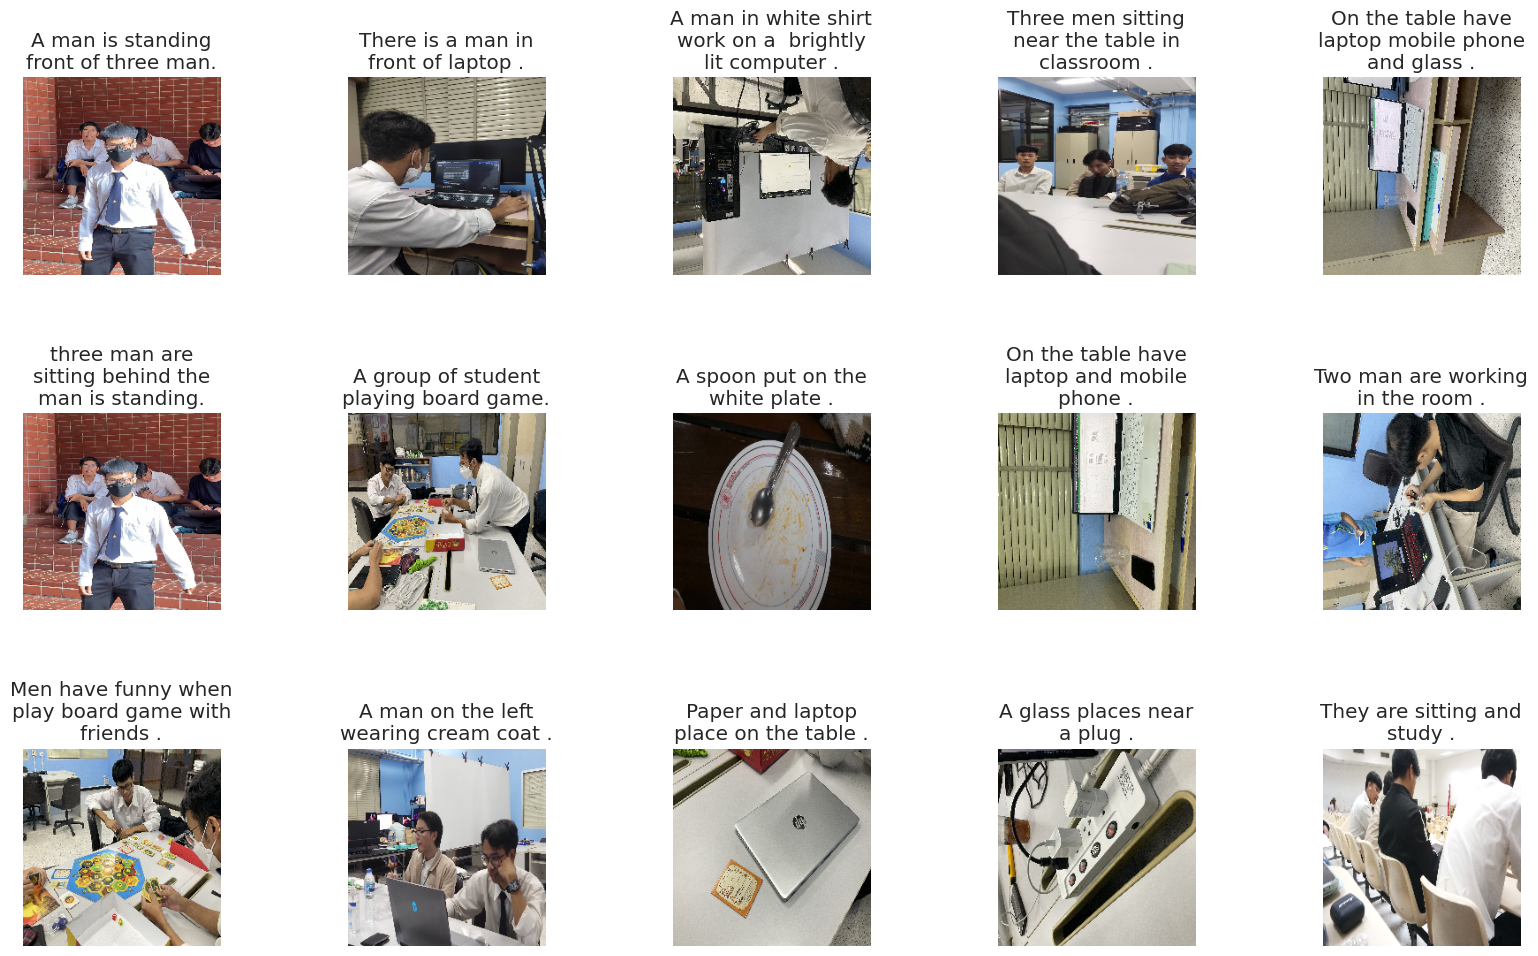

In [ ]:
display_images(data.sample(15))

# Process caption data
- Change to lower case
- Delete
- Add space and concatenate]

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq student use computer on white table endseq',
 'startseq man in white shirt is play computer endseq',
 'startseq student install programe on computer endseq',
 'startseq student sitting on the chair and work on computer endseq',
 'startseq man in white shirt work on brightly lit computer endseq',
 'startseq two man do something near the table endseq',
 'startseq one man in blue shirt and one man in green shirt stand around table endseq',
 'startseq man in blue shirt was bending over to pick up thing on white table endseq',
 'startseq man in blue shirt wear sport pants stand in front of white table endseq',
 'startseq two man stand opposite each other with table in the middle endseq']

# Data preparation

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1  # return size of all vocab in our captions
max_length = max(len(caption.split()) for caption in captions) # return the length of the longest message

images = data['image'].unique().tolist() # return unique image
nimages = len(images) # return number of unique image

split_index = round(0.85*nimages)   # Position for split data to train and test
train_images = images[:split_index]   # Train image data
val_images = images[split_index:]   # Validataion image data

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 5, 7, 11, 13, 6, 46, 30, 2]

# Train an image model and import the output values feed to another LSTM model

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 [==============================] - 5s 0us/step


100%|██████████| 93/93 [01:28<00:00,  1.06it/s]


In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

# Create LSTM model for train caption
- input have 2 values
    - values from above model
    - caption after tokenize]

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
from tensorflow.keras.utils import plot_model

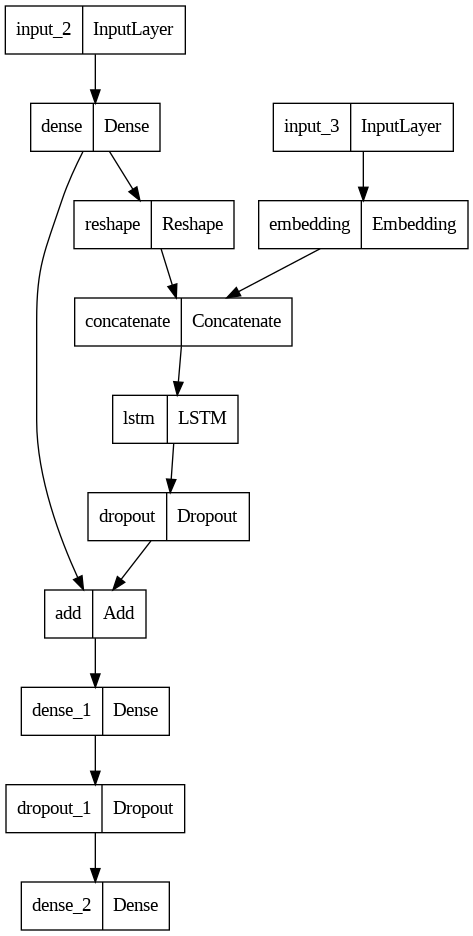

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  491776    ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 256)               0         ['dense[0][0]']               
                                                                                            

In [ ]:
train

,image,caption
0,IMG_0225.JPG,startseq student use computer on white table e...
1,IMG_0225.JPG,startseq man in white shirt is play computer e...
2,IMG_0225.JPG,startseq student install programe on computer ...
3,IMG_0225.JPG,startseq student sitting on the chair and work...
4,IMG_0225.JPG,startseq man in white shirt work on brightly l...
...,...,...
390,IMG_20231007_130500.jpg,startseq there is two man standing on the floo...
391,IMG_20231007_130500.jpg,startseq this two man wearing black shirt endseq
392,IMG_20231007_130500.jpg,startseq man in the front is wearing black shi...
393,IMG_20231007_130500.jpg,startseq man in the back is wearing black shir...


# Create train and validate data

In [ ]:
# train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
#                                       tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

# validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
#                                       tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=1,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=1,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
print("X_col:", train_generator.X_col)
print("y_col:", train_generator.y_col)
print("batch_size:", train_generator.batch_size)
print("directory:", train_generator.directory)
print("tokenizer:", train_generator.tokenizer)
print("vocab_size:", train_generator.vocab_size)
print("max_length:", train_generator.max_length)
print("features:", train_generator.features)

X_col: image
y_col: caption
batch_size: 1
directory: /content/drive/MyDrive/MachineLearning/project/Image
tokenizer: <keras.src.preprocessing.text.Tokenizer object at 0x7951b2e262f0>
vocab_size: 334
max_length: 16
features: {'IMG_0225.JPG': array([[2.0515383e-04, 1.3278573e-03, 5.6743954e-04, ..., 4.2791677e-01,
        7.6076001e-01, 5.0577146e-01]], dtype=float32), 'IMG_0226.JPG': array([[2.0323211e-04, 2.8156416e-04, 8.5162616e-04, ..., 1.9039835e-01,
        1.4932016e+00, 3.4941867e-01]], dtype=float32), 'IMG_0227.JPG': array([[1.9553628e-04, 8.8009605e-04, 7.2038296e-04, ..., 7.2841650e-01,
        1.6335633e+00, 4.6738455e-01]], dtype=float32), 'IMG_0228.JPG': array([[2.2092134e-04, 4.0794956e-04, 8.7301800e-04, ..., 9.4103312e-01,
        3.3275804e-01, 0.0000000e+00]], dtype=float32), 'IMG_0229.JPG': array([[1.6967941e-04, 9.0973370e-04, 1.0674535e-03, ..., 6.3249522e-01,
        4.0226075e-01, 1.3299739e-01]], dtype=float32), 'IMG_0230.JPG': array([[1.5889156e-04, 9.4937108e-

In [ ]:
train_generator.features['IMG_0225.JPG'].shape

(1, 1920)

In [ ]:
batch_data = next(train_generator)
caption_features = batch_data['caption_features']

TypeError: ignored

# Train LSTM model

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
394/395 [============================>.] - ETA: 0s - loss: 4.5233
Epoch 1: val_loss improved from inf to 4.61096, saving model to model.h5
395/395 [==============================] - 11s 12ms/step - loss: 4.5223 - val_loss: 4.6110 - lr: 0.0010
Epoch 2/50
392/395 [============================>.] - ETA: 0s - loss: 3.8317
Epoch 2: val_loss improved from 4.61096 to 4.46023, saving model to model.h5
395/395 [==============================] - 3s 8ms/step - loss: 3.8294 - val_loss: 4.4602 - lr: 0.0010
Epoch 3/50
395/395 [==============================] - ETA: 0s - loss: 3.3838
Epoch 3: val_loss improved from 4.46023 to 4.42884, saving model to model.h5
395/395 [==============================] - 4s 10ms/step - loss: 3.3838 - val_loss: 4.4288 - lr: 0.0010
Epoch 4/50
392/395 [============================>.] - ETA: 0s - loss: 3.0353
Epoch 4: val_loss improved from 4.42884 to 4.42359, saving model to model.h5
395/395 [==============================] - 3s 8ms/step - loss: 3.0399 - val_los

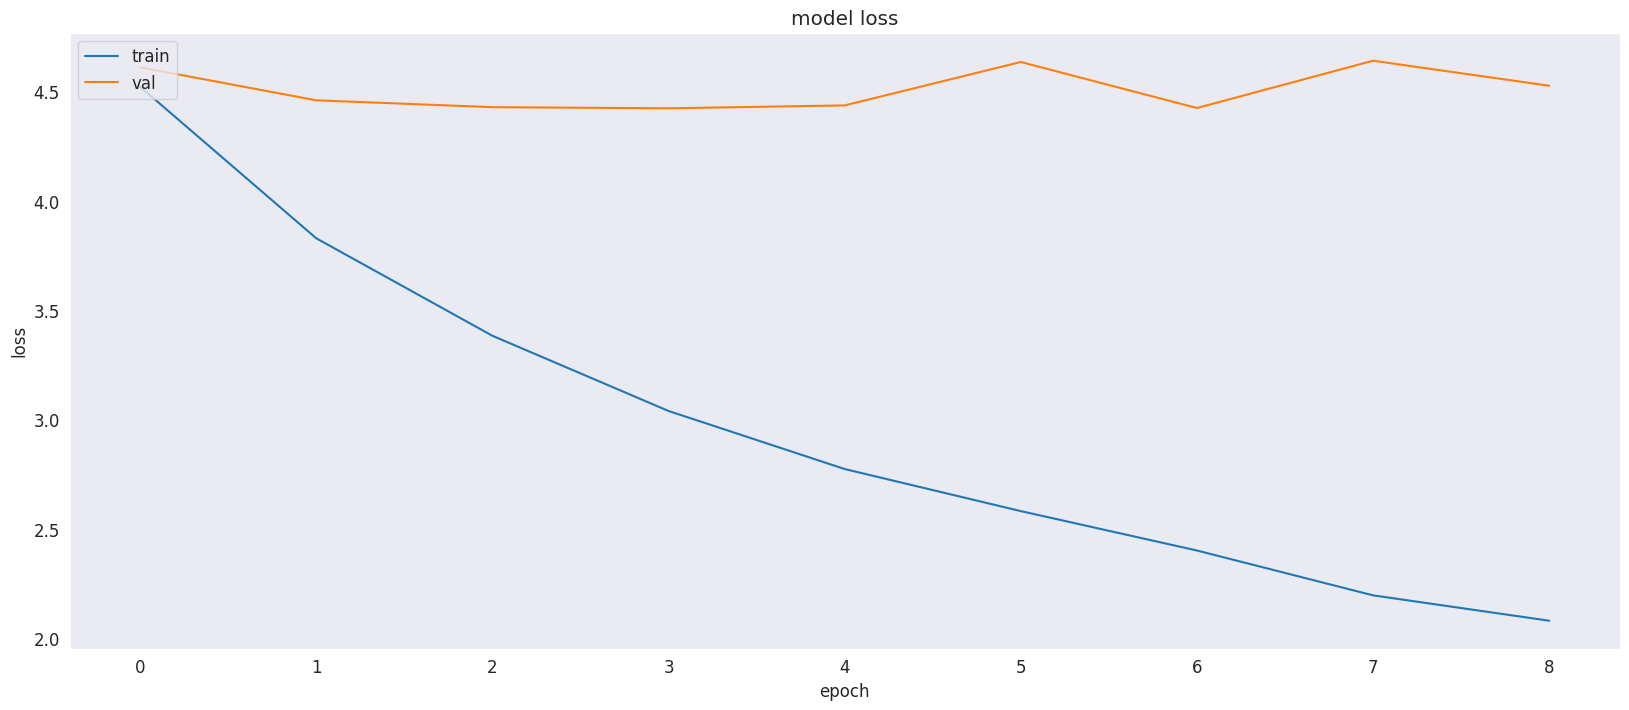

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Predict part

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
def predict_caption_outsite(model, image, tokenizer, max_length, features):

    img = load_img(os.path.join("/content/drive/MyDrive/MachineLearning/project/Flicker8k_Dataset/",  image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
samples = train.sample(15)
samples.reset_index(drop=True,inplace=True)
for index,record in samples.iterrows():
    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    print(record['image'])
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

190250.jpg
1/1 [==============================] - 0s 18ms/step
IMG_0240.JPG
1/1 [==============================] - 0s 17ms/step
IMG_25660821_091854.jpg
1/1 [==============================] - 0s 21ms/step
190251.jpg
1/1 [==============================] - 0s 23ms/step
190250.jpg
1/1 [==============================] - 0s 20ms/step
192437_0.jpg
1/1 [==============================] - 0s 18ms/step
192444_0.jpg
1/1 [==============================] - 0s 21ms/step
IMG_25660912_121752.jpg
1/1 [==============================] - 0s 18ms/step
IMG_25660913_132521.jpg
1/1 [==============================] - 0s 18ms/step
IMG_25660915_120732.jpg
1/1 [==============================] - 0s 21ms/step
IMG_25660913_132501.jpg
1/1 [==============================] - 0s 19ms/step
IMG_25660914_092811.jpg
1/1 [==============================] - 0s 30ms/step
IMG_25660911_083155.jpg
1/1 [==============================] - 0s 27ms/step
IMG_25660915_083048.jpg
1/1 [==============================] - 0s 26ms/step
IMG_0258

In [ ]:
samples

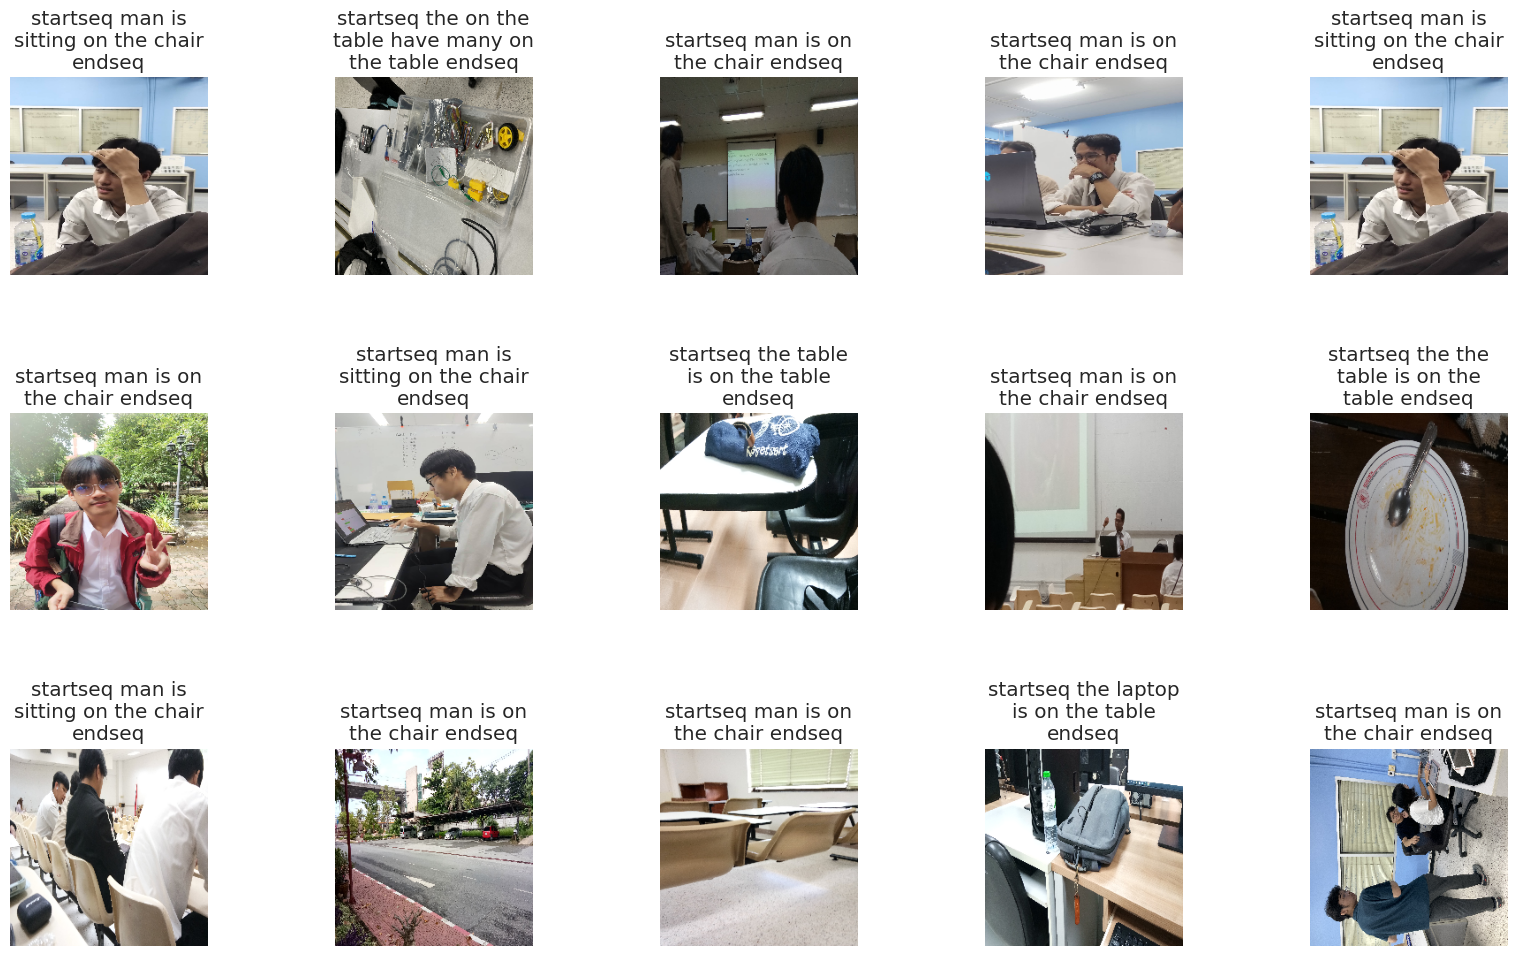

In [ ]:
display_images(samples)

1/1 [==============================] - 0s 18ms/step
startseq man is on the chair endseq


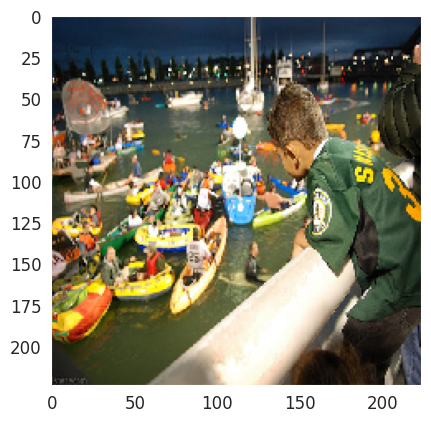

In [ ]:
img = load_img(os.path.join("/content/drive/MyDrive/MachineLearning/project/Flicker8k_Dataset/", "1042020065_fb3d3ba5ba.jpg"),target_size=(224,224))
plt.imshow(img)
caption = predict_caption_outsite(caption_model, "1042020065_fb3d3ba5ba.jpg", tokenizer, max_length, features)
print(caption)

In [ ]:
sequence = tokenizer.texts_to_sequences(["startseq"])[0]
sequence = pad_sequences([sequence], 3)

In [ ]:
sequence
#revise sentense caption in picture
#Ex. subject verb object adverb and adjective
#label encoding
#structure model for sentense
#loss = ?

array([[0, 0, 1]], dtype=int32)